# Learning the Kantorovich Dual using Input Convex Neural Networks

In this tutorial, we explore how to learn the solution of the Kantorovich dual based on parameterizing the two dual potentials $f$ and $g$ with two [input convex neural networks (ICNN)](http://proceedings.mlr.press/v70/amos17b/amos17b.pdf), a method developed by [Makkuva et al. (2020)](http://proceedings.mlr.press/v119/makkuva20a/makkuva20a.pdf). For more insights on the approach itself, we refer the user to the original publication.
Given dataloaders containing samples of the *source* and the *target* distribution, `OTT`'s `NeuralDualSolver` finds the pair of optimal potentials $f$ and $g$ to solve the corresponding dual of the optimal transport problem. Once a solution has been found, this can be used to transport unseen source data samples to its target distribution (or vice-versa) or compute the corresponding distance between new source and target distribution.

In [1]:
import jax
import jax.numpy as jnp
from flax.training import checkpoints
import numpy as np
import optax
import matplotlib
import matplotlib.pyplot as plt
from torch.utils.data import IterableDataset
from torch.utils.data import DataLoader
from ott.tools.sinkhorn_divergence import sinkhorn_divergence
from ott.geometry import pointcloud
from ott.core.neuraldual import NeuralDualSolver
from ott.core import icnn

import umap
from sklearn.decomposition import PCA

## Helper Functions

Let us define some helper functions which we use for the subsequent analysis.

In [2]:
def plot_potential_map(neural_dual, data, embedding, inverse=False):
    """Plot data and learned potential."""
    
    if not inverse:
        potential = neural_dual.g.apply_fn({'params': neural_dual.g.params}, data)
    else:
        potential = neural_dual.f.apply_fn({'params': neural_dual.f.params}, data)
        
    # Log scale potential, +1 because log(1)=0
    potential = np.log(potential + 1)
    plt.scatter(embedding[:, 0], embedding[:, 1], c=potential, alpha=0.5)
    plt.colorbar()

In [3]:
def plot_ot_map(neural_dual, source, target, mapper, inverse=False):
    """Plot data and learned optimal transport map."""

    def draw_arrows(a, b):
        plt.arrow(a[0], a[1], b[0] - a[0], b[1] - a[1],
                  color=[0.5, 0.5, 1], alpha=0.3)
        
    batch_size = source.shape[0]
    if not inverse:
      grad_state_s = neural_dual.transport(source)
    else:
      grad_state_s = neural_dual.inverse_transport(target)
    
    # Apply dimensionality reduction
    embedding = mapper.transform(np.concatenate([grad_state_s, target, source], axis=0))
    embedding_grad_state = embedding[:batch_size]
    
    # This is to adjust the plotting depending on Inverse param
    if not inverse:
        embedding_target = embedding[batch_size:batch_size*2]
        embedding_source = embedding[batch_size*2:]
    else:
        embedding_source = embedding[batch_size:batch_size*2]
        embedding_target = embedding[batch_size*2:]
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    ax.scatter(embedding_target[:, 0], embedding_target[:, 1], color='#A7BED3',
               alpha=0.5, label=r'$target$')
    ax.scatter(embedding_source[:, 0], embedding_source[:, 1], color='#1A254B',
               alpha=0.5, label=r'$source$')
    if not inverse:
        ax.scatter(embedding_grad_state[:, 0], embedding_grad_state[:, 1], color='#F2545B',
               alpha=0.5, label=r'$\nabla g(source)$')
    else:
        ax.scatter(embedding_grad_state[:, 0], embedding_grad_state[:, 1], color='#F2545B',
                   alpha=0.5, label=r'$\nabla f(target)$')
    
    plt.legend()

    for i in range(embedding_grad_state.shape[0]):
        draw_arrows(embedding_source[i, :], embedding_grad_state[i, :])

In [4]:
def plot_data(source, target):
    """Plot data."""

    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.scatter(target[:, 0], target[:, 1], color='red',
               alpha=0.5, label=r'$target$')
    ax.scatter(source[:, 0], source[:, 1], color='blue',
               alpha=0.5, label=r'$source$')

    plt.legend()

In [5]:
def get_optimizer(optimizer, lr, b1, b2, eps):
  """Returns a flax optimizer object based on `config`."""

  if optimizer == 'Adam':
      optimizer = optax.adam(learning_rate=lr, b1=b1, b2=b2, eps=eps)
  elif optimizer == 'SGD':
      optimizer = optax.sgd(learning_rate=lr, momentum=None, nesterov=False)
  else:
      raise NotImplementedError(
          f'Optimizer {optimizer} not supported yet!')

  return optimizer

In [6]:
@jax.jit
def sinkhorn_loss(x, y, epsilon=0.1, power=2.0):
    """Computes transport between (x, a) and (y, b) via Sinkhorn algorithm."""
    a = jnp.ones(len(x)) / len(x)
    b = jnp.ones(len(y)) / len(y)

    sdiv = sinkhorn_divergence(pointcloud.PointCloud, x, y, power=power,
                               epsilon=epsilon, a=a, b=b)
    return sdiv.divergence

In [7]:
def get_2dmgrid(num_points, start, stop):
    """Creates an evenly-spaced 2d meshgrid"""
    x = np.linspace(start, stop, num_points)
    y = np.linspace(start, stop, num_points)
    xv, yv = np.meshgrid(x, y)
    xv = np.reshape(xv, [-1])
    yv = np.reshape(yv, [-1])
    mgrid = np.stack([xv, yv]).T
    return mgrid

In [8]:
def restore_ckpt(ckpt_dir, neural_dual):
    """Load and apply a checkpoint to a given neural dual"""
    state_f = neural_dual.state_f
    neural_dual.state_f = checkpoints.restore_checkpoint(ckpt_dir=f"{ckpt_dir}/neural_f", target=state_f)
    
    state_g = neural_dual.state_g
    neural_dual.state_g = checkpoints.restore_checkpoint(ckpt_dir=f"{ckpt_dir}/neural_g", target=state_g)

## Setup Training and Validation Datasets

We apply the `NeuralDual` to compute the transport between toy datasets. In this tutorial, the user can choose between the datasets `simple` (data clustered in one center), `circle` (two-dimensional Gaussians arranged on a circle), `square_five` (two-dimensional Gaussians on a square with one Gaussian in the center), and `square_four` (two-dimensional Gaussians in the corners of a rectangle).

In [9]:
class HighDimToyDataset(IterableDataset):
    def __init__(self, name, input_dim):
        self.name = name
        self.input_dim = input_dim
        self.rng = np.random.default_rng()

    def __iter__(self):
        return self.create_sample_generators()

    def create_sample_generators(self):
        # given name of dataset, select centers
        if self.name == "close_gaussians":
            centers = np.array([[1] + [1] * (input_dim-1),
                               [1] + [-1] * (input_dim-1)])
        elif self.name == "distant_gaussians":
            centers = np.array([[3] + [3] * (self.input_dim-1),
                               [3] + [-3] * (self.input_dim-1)])
        else:
            raise NotImplementedError()
        
        # Scaled identity matrix as covariance
        K = np.eye(self.input_dim) * (1/5 + 1e-4)
        # Get cholesky decomposition for efficient sampling
        L = np.linalg.cholesky(K)
        
        while True:
            # Sample from centers
            center = centers[np.random.choice(len(centers))]
            # Sample from multivariate Gaussian given center
            u = np.random.normal(loc=0, scale=1, size=self.input_dim)
            point = center + np.dot(L, u)
            yield point


def load_high_dim_toy_data(name_source: str,
                  name_target: str,
                  batch_size: int = 1024,
                  valid_batch_size: int = 1024,
                  input_dim: int = 5):
    dataloaders = (
      iter(DataLoader(HighDimToyDataset(name_source, input_dim), batch_size=batch_size)),
      iter(DataLoader(HighDimToyDataset(name_target, input_dim), batch_size=batch_size)),
      iter(DataLoader(HighDimToyDataset(name_source, input_dim), batch_size=valid_batch_size)),
      iter(DataLoader(HighDimToyDataset(name_target, input_dim), batch_size=valid_batch_size)),
    )
    return dataloaders, input_dim

## Solve Neural Dual

In order to solve the neural dual, we need to define our dataloaders. The only requirement is that the corresponding source and target train and validation datasets are *iterators*.

In [10]:
(dataloader_source, dataloader_target, _, _), input_dim = load_high_dim_toy_data('close_gaussians', 'distant_gaussians', input_dim=5)

Next, we define the architectures parameterizing the dual potentials $f$ and $g$. These need to be parameterized by ICNNs. You can adapt the size of the ICNNs by passing a sequence containing hidden layer sizes. While ICNNs are by default containing partially positive weights, we can solve the `NeuralDual` using approximations to this positivity constraint (via weight clipping and a weight penalization). For this, set `positive weights` to True in both the `ICNN` architecture and `NeuralDualSolver` configuration. For more details on how to customize the ICNN architectures, we refer you to the documentation.

In [11]:
# initialize models
neural_f = icnn.ICNN(dim_hidden=[64, 64, 64, 64])
neural_g = icnn.ICNN(dim_hidden=[64, 64, 64, 64])

# initialize optimizers
optimizer_f = get_optimizer('Adam', lr=0.0001, b1=0.5, b2=0.9, eps=0.00000001)
optimizer_g = get_optimizer('Adam', lr=0.0001, b1=0.5, b2=0.9, eps=0.00000001)

We then initialize the `NeuralDualSolver` by passing the two ICNN models parameterizing $f$ and $g$, as well as by specifying the input dimensions of the data and the number of training iterations to execute. Once the `NeuralDualSolver` is initialized, we can obtain the `NeuralDual` by passing the corresponding dataloaders to it, which will subsequently return the optimal `NeuralDual` for the problem. As here our training and validation datasets do not differ, we pass (`dataloader_source`, `dataloader_target`) for both training and validation steps. For more details on how to configer the `NeuralDualSolver`, we refer you to the documentation.

In [12]:
# Train neural dual, change num_train_iters to train
neural_dual_solver = NeuralDualSolver(
    input_dim, neural_f, neural_g, optimizer_f, optimizer_g, num_train_iters=0)
neural_dual = neural_dual_solver(
    dataloader_source, dataloader_target, dataloader_source, dataloader_target)

0it [00:00, ?it/s]


In [13]:
# Instead of training, restore a trained checkpoint
# ! Still need to call cell beforehand
restore_ckpt(ckpt_dir="checkpoints/5_dim_gaussian", neural_dual=neural_dual)

## Evaluate Neural Dual

In [14]:
batch_size = 1024
(dataloader_source, dataloader_target, _, _), input_dim = load_high_dim_toy_data('close_gaussians', 'distant_gaussians', batch_size=batch_size, input_dim=5)

After training has completed successfully, we can evaluate the `NeuralDual` on unseen incoming data. We first sample a new batch from the source and target distribution.

In [15]:
# Get test data
data_source = next(dataloader_source).numpy()
data_target = next(dataloader_target).numpy()
data = np.concatenate([data_source, data_target], axis=0)

In [16]:
# Train dimensionality reducer on test data
dim_reduce = "pca"

if dim_reduce == "pca":
    mapper = PCA(n_components=2)
    mapper.fit(data)
elif dim_reduce == "umap":
    mapper = umap.UMAP().fit(data)

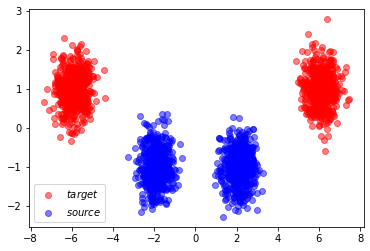

In [17]:
# Get test embedding and plot it in 2D
embedding = mapper.transform(data)

embedding_source = embedding[:batch_size]
embedding_target = embedding[batch_size:]

plot_data(embedding_source, embedding_target)

Now we can plot the corresponding transport from source to target using the gradient of the learning potential `NeuralDual.g`, i.e., $\nabla g(\text{source})$, or from target to source via the gradient of the learning potential `NeuralDual.f`, i.e., $\nabla f(\text{target})$.

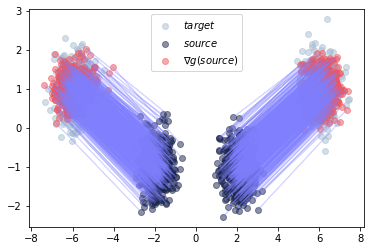

In [18]:
plot_ot_map(neural_dual, data_source, data_target, mapper=mapper, inverse=False)

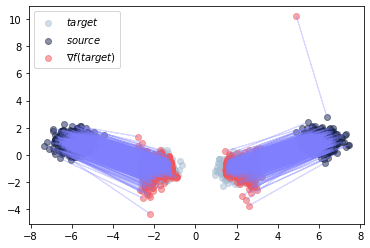

In [19]:
plot_ot_map(neural_dual, data_source, data_target, mapper=mapper, inverse=True)

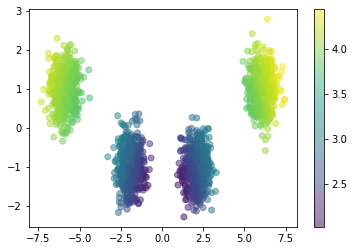

In [20]:
plot_potential_map(neural_dual, data, embedding, inverse=False)

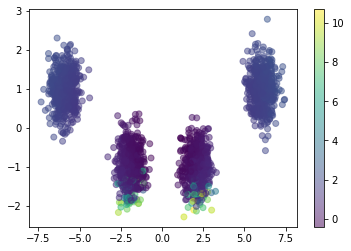

In [21]:
plot_potential_map(neural_dual, data, embedding, inverse=True)

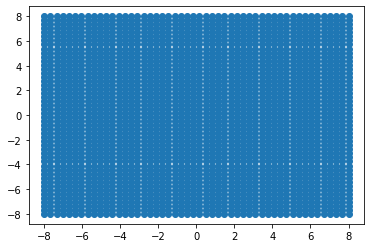

In [22]:
# Get 2D meshgrid, adjust for desired coordinates
mgrid = get_2dmgrid(num_points=50, start=-8, stop=8)

# Map to high dim embedding
high_dim_embedding = mapper.inverse_transform(mgrid)
# Map backwards to low dim and plot
low_dim_emb = mapper.transform(high_dim_embedding)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(low_dim_emb[:, 0], low_dim_emb[:, 1])
plt.show()

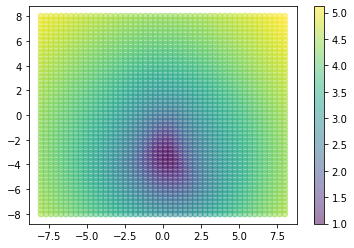

In [23]:
plot_potential_map(neural_dual, high_dim_embedding, mgrid, inverse=False)

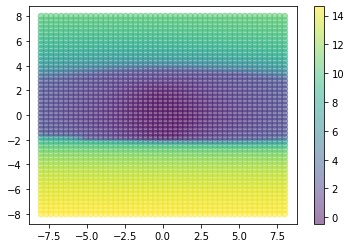

In [24]:
plot_potential_map(neural_dual, high_dim_embedding, mgrid, inverse=True)

In [25]:
# Train dimensionality reducer on test data
dim_reduce = "umap"

if dim_reduce == "pca":
    mapper = PCA(n_components=2)
    mapper.fit(data)
elif dim_reduce == "umap":
    mapper = umap.UMAP().fit(data)

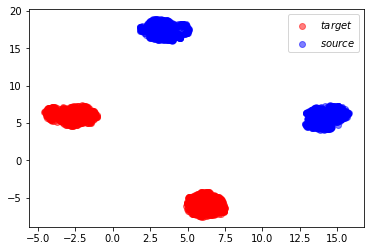

In [26]:
# Get test embedding and plot it in 2D
embedding = mapper.transform(data)
embedding_source = embedding[:batch_size]
embedding_target = embedding[batch_size:]

plot_data(embedding_source, embedding_target)

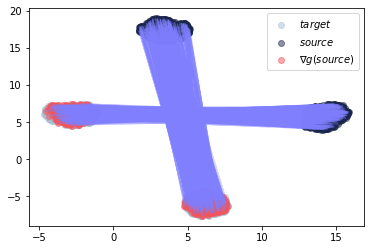

In [27]:
plot_ot_map(neural_dual, data_source, data_target, mapper=mapper, inverse=False)

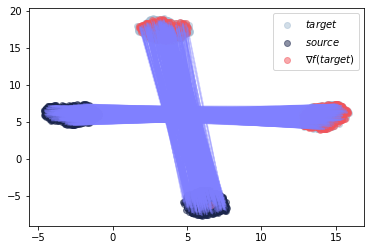

In [28]:
plot_ot_map(neural_dual, data_source, data_target, mapper=mapper, inverse=True)

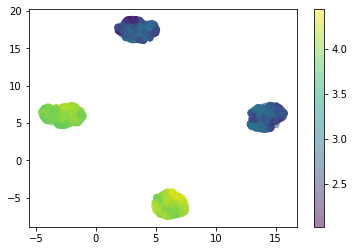

In [29]:
plot_potential_map(neural_dual, data, embedding, inverse=False)

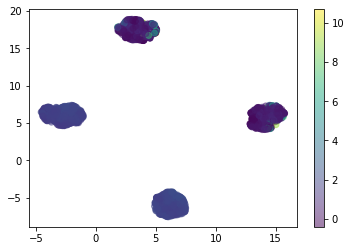

In [30]:
plot_potential_map(neural_dual, data, embedding, inverse=True)

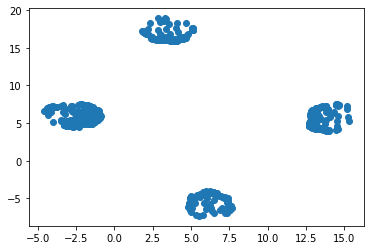

In [40]:
# Get 2D meshgrid, adjust for desired coordinates
mgrid = get_2dmgrid(num_points=50, start=-10, stop=20)


# Map to high dim embedding
high_dim_embedding = mapper.inverse_transform(mgrid)
# Map backwards to low dim and plot
low_dim_embedding = mapper.transform(high_dim_embedding)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(low_dim_embedding[:, 0], low_dim_embedding[:, 1])
plt.show()

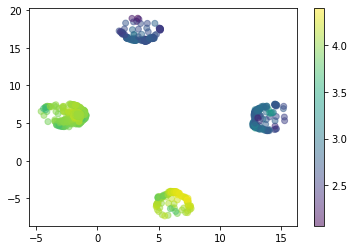

In [41]:
plot_potential_map(neural_dual, high_dim_embedding, low_dim_embedding, inverse=False)

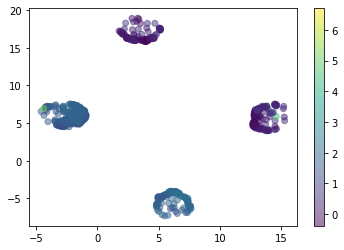

In [42]:
plot_potential_map(neural_dual, high_dim_embedding, low_dim_embedding, inverse=True)

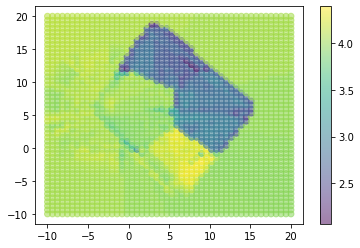

In [43]:
plot_potential_map(neural_dual, high_dim_embedding, mgrid, inverse=False)

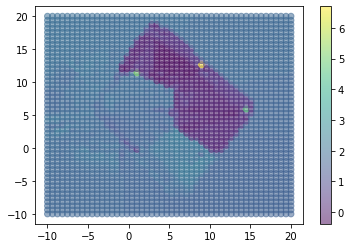

In [44]:
plot_potential_map(neural_dual, high_dim_embedding, mgrid, inverse=True)

We further test, how close the predicted samples are to the sampled data.

First for potential $g$, transporting source to target samples. Ideally the resulting Sinkhorn distance is close to 0.

In [36]:
pred_target = neural_dual.transport(data_source)
print(f'Sinkhorn distance between predictions and data samples: {sinkhorn_loss(pred_target, data_target)}')

Sinkhorn distance between predictions and data samples: 0.16419929265975952


Then for potential $f$, transporting target to source samples. Again, the resulting Sinkhorn distance needs to be close to 0.

In [37]:
pred_source = neural_dual.inverse_transport(data_target)
print(f'Sinkhorn distance between predictions and data samples: {sinkhorn_loss(pred_source, data_source)}')

Sinkhorn distance between predictions and data samples: 0.8294318914413452


Besides computing the transport and mapping source to target samples or vice versa, we can also compute the overall distance between new source and target samples.

In [38]:
neural_dual_dist = neural_dual.distance(data_source, data_target)
print(f'Neural dual distance between source and target data: {neural_dual_dist}')

Neural dual distance between source and target data: 19.9361515045166


Which compares to the primal Sinkhorn distance in the following.

In [39]:
sinkhorn_dist = sinkhorn_loss(data_source, data_target)
print(f'Sinkhorn distance between source and target data: {sinkhorn_dist}')

Sinkhorn distance between source and target data: 20.080537796020508


In [ ]:
# Save a checkpoint
checkpoints.save_checkpoint("checkpoints/5_dim_gaussian/neural_f", neural_dual_solver.state_f, step=0)
checkpoints.save_checkpoint("checkpoints/5_dim_gaussian/neural_g", neural_dual_solver.state_g, step=0)